In [2]:
import os
import sys
ROOT = os.getenv('BONNER_ROOT_PATH')
sys.path.append(ROOT)
from model_evaluation.results.predicting_brain_data.tools import plot_results
from model_evaluation.utils import get_best_layer_iden, get_scores_iden
from model_features.models.models import load_model_dict
from config import CACHE
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import torch

# Simple ST

In [2]:
def make_pandas_df(dataset, regions, subjects, gpool, identifier):
    
    df = pd.DataFrame()
    index = 0        
    
    for region in regions:
        identifier = identifier + '_' + region

        data = xr.open_dataset(os.path.join(CACHE,'encoding_scores_torch',identifier), engine='h5netcdf')

        for subject in subjects:
            subject_data = data.where(data.subject == subject, drop=True)
            mean_r = subject_data.r_value.values.mean()

            df_tmp =  pd.DataFrame({'score':mean_r,
                                    'size':M,
                                    'iden':identifier,
                                    'J':J,
                                    'L':L,
                                    'region':region,
                                    'subject':subject},index=[index])
            df = pd.concat([df,df_tmp])
            index+=1

    return df

In [6]:
subjects = [i for i in range(8)]
DATASET='naturalscenes'
regions=['general']
MAX_POOL = True
RANDOM_PROJ = None
GLOBAL_POOL = False 
M, N = 224, 224

In [7]:
dfs = []
    
for J in [5,6]:  
    for L in [8]:

        if GLOBAL_POOL:
            activations_identifier = 'scat_transfom' + '_'+ f'J={J}_L={L}_M={M}_N={N}' + '_' + DATASET

        elif RANDOM_PROJ is not None or (J== 5 and L==12):
            RANDOM_PROJ = 1000
            activations_identifier = 'scat_transfom' + '_' + f'randproj={RANDOM_PROJ}' + '_' + f'J={J}_L={L}_M={M}_N={N}' + '_' + 'gpool=False' + '_' + DATASET                

        else:
            activations_identifier = 'scat_transfom' + '_' + f'maxpool' + '_' +  f'J={J}_L={L}_M={M}_N={N}' + '_' + 'gpool=False' + '_' + DATASET

        dfs.append(make_pandas_df(DATASET, regions, subjects, GLOBAL_POOL, activations_identifier))
        RANDOM_PROJ = None


In [8]:
df = pd.concat(dfs)
df['model'] = df[['J','L']].apply(lambda x: 'J=' + str(x.J) + '_' + 'L=' + str(x.L), axis=1)
df = df.groupby(['L','J']).mean().reset_index()

In [9]:
df

,L,J,score,size,subject
0,8,5,0.223353,224.0,3.5
1,8,6,0.221703,224.0,3.5


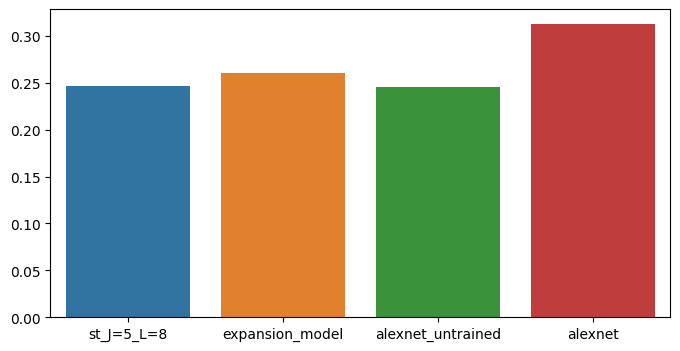

In [20]:
region = 'V4'

scores = []
idens = [f'scat_transfom_maxpool_J=5_L=8_M=224_N=224_gpool=False_naturalscenes_{region}', 
         f'expansion_model_3_layers_10000_features_gpool=False_naturalscenes_{region}',
         f'alexnet_untrained_gpool=False_naturalscenes_{region}',
         f'alexnet_gpool=False_naturalscenes_{region}']

for iden in idens:
    scores.append(float(xr.open_dataset(os.path.join(CACHE,'encoding_scores_torch',iden), engine='h5netcdf').r_value.mean()))
    
    
    
    plt.clf()
rcParams['figure.figsize'] = (8,4)  
names = ['st_J=5_L=8', 'expansion_model','alexnet_untrained','alexnet']
sns.barplot(x = names, y = scores)
plt.savefig(f'comparison_{region}.png', bbox_inches='tight', dpi=100) 

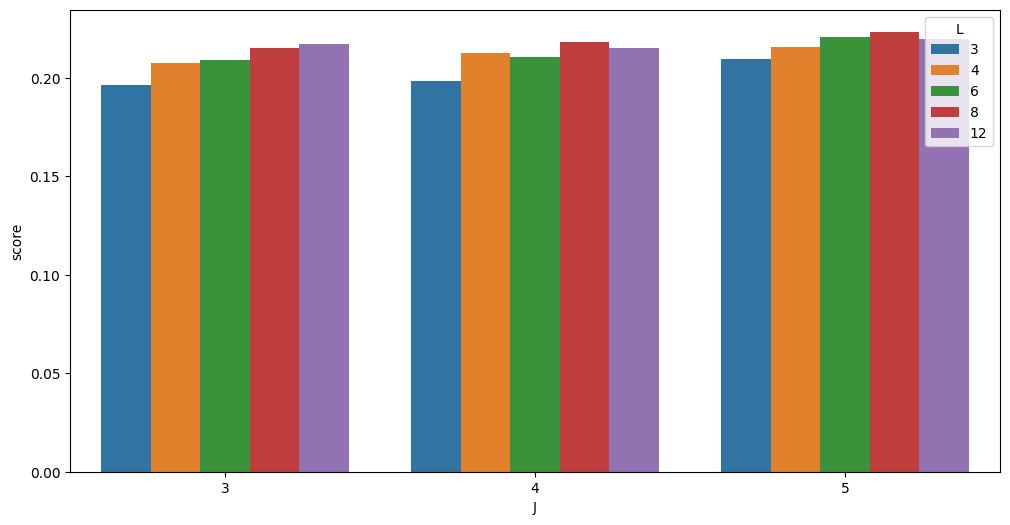

In [51]:
plt.clf()
rcParams['figure.figsize'] = (12,6)  

sns.barplot(x = df.J, y = df['score'], hue=df.L, errorbar="sd")
plt.savefig(f'scat_transform_avgpool.png', bbox_inches='tight', dpi=100) 

In [17]:
import seaborn as sns
sns.barplot(x = df.model, y = df['score'], errorbar="sd")

AttributeError: 'DataFrame' object has no attribute 'model'

# Rainbow

In [20]:
layer_names = []
scores = []
import re

path = '/data/atlas/rainbow_models/Pr_Norm/batchsize_128_lrfreq_45_best.pth.tar'
model = load_model()
checkpoint = torch.load(path)
state_dict = checkpoint["state_dict"]
state_dict = {key.replace("(0, 0)", "0"): value for key, value in state_dict.items()}
checkpoint["state_dict"] = state_dict
model.load_state_dict(checkpoint['state_dict'])

label = []
scores = []


for num_layers in range(6,12):
    
    data = xr.open_dataset(f'/data/atlas/.cache/encoding_scores_torch/rainbow_trained_Pr_Norm_{num_layers}L_general',engine='netcdf4')
    scores.append(float(data.r_value.mean()))
    
    m = model[:num_layers+1]


    c = 0
    for layer in range(1,num_layers+1):

        module = str(m[layer][-2])
        match = re.search(r'out_channels=(\d+)R', module)
        out_channels = int(match.group(1))
        c += out_channels
    
    label.append(f'layer={num_layers}, params={c}')


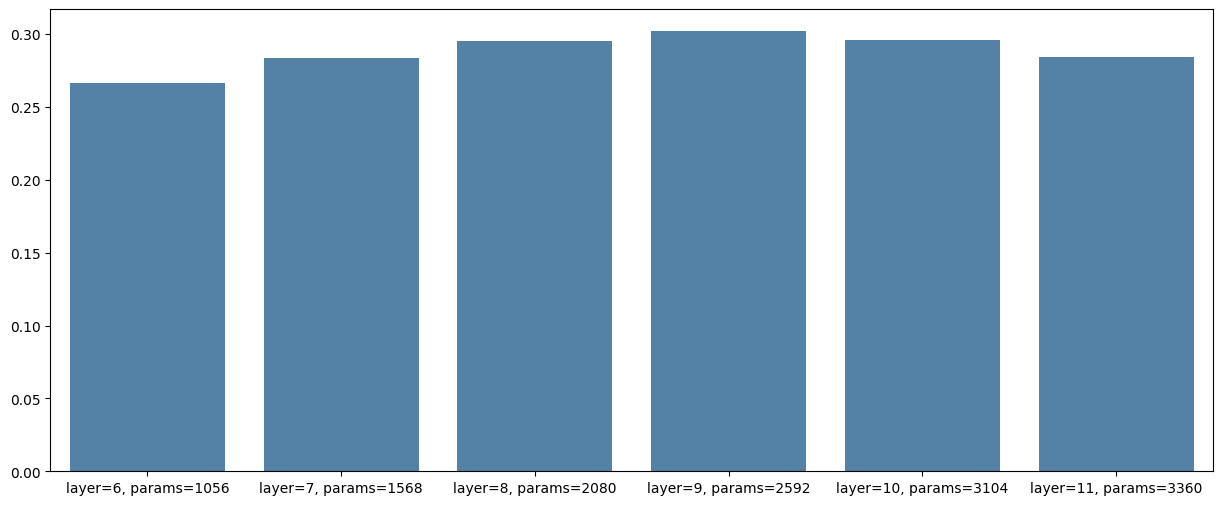

In [24]:
plt.clf()
rcParams['figure.figsize'] = (15,6)  

sns.barplot(x = label, y = scores, color='steelblue')
plt.savefig(f'rainbow_layers.png', bbox_inches='tight', dpi=100) 

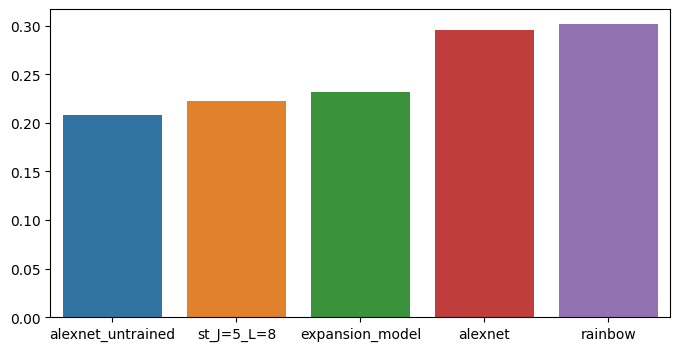

In [25]:
region = 'general'

scores = []
idens = [f'alexnet_untrained_gpool=False_naturalscenes_{region}',
         f'scat_transform_J=5_L=8_M=224_N=224_gpool=False_naturalscenes_{region}', 
         f'expansion_model_3_layers_10000_features_gpool=False_naturalscenes_{region}',
         f'alexnet_gpool=False_naturalscenes_{region}',
         f'rainbow_trained_Pr_Norm_9L_{region}']

for iden in idens:
    scores.append(float(xr.open_dataset(os.path.join(CACHE,'encoding_scores_torch',iden), engine='h5netcdf').r_value.mean()))
    
    
    plt.clf()
rcParams['figure.figsize'] = (8,4)  
names = ['alexnet_untrained','st_J=5_L=8','expansion_model','alexnet','rainbow']
sns.barplot(x = names, y = scores)
plt.savefig(f'comparison_{region}.png', bbox_inches='tight', dpi=100) 

In [ ]:
xr.open_dataset('/data/atlas/.cache/encoding_scores_torch/rainbow_no_norm_32_1024_5000_general').r_value.mean()

In [2]:
xr.open_dataset('/data/atlas/.cache/encoding_scores_torch/rainbow_no_norm_32_128_256_512_1024_2048_4096_general').r_value.mean()

<xarray.DataArray 'r_value' ()>
array(0.17858631)

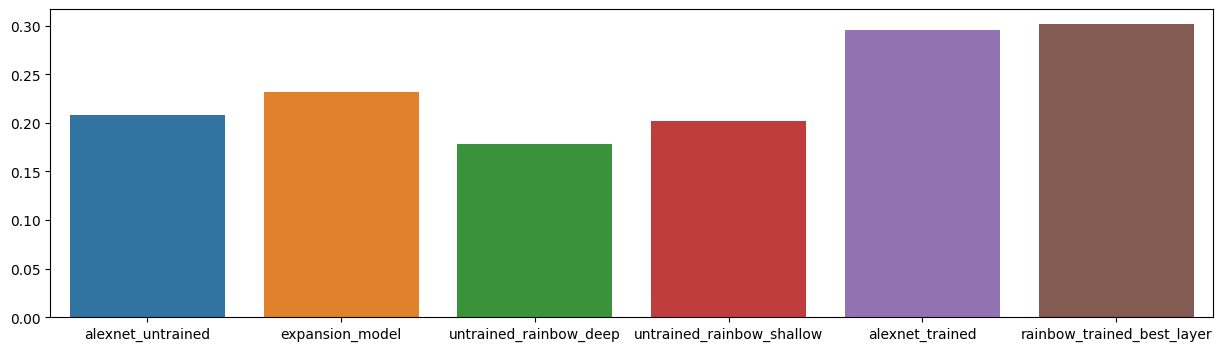

In [14]:
region = 'general'

scores = []
idens = [f'alexnet_untrained_gpool=False_naturalscenes_{region}',
         f'expansion_model_3_layers_10000_features_gpool=False_naturalscenes_{region}',
         f'rainbow_no_norm_32_128_256_512_1024_2048_4096_{region}',
         f'rainbow_no_norm_32_1024_5000_{region}',
         f'alexnet_gpool=False_naturalscenes_{region}',
         f'rainbow_trained_Pr_Norm_9L_{region}']

for iden in idens:
    scores.append(float(xr.open_dataset(os.path.join(CACHE,'encoding_scores_torch',iden), engine='h5netcdf').r_value.mean()))
    
    
    plt.clf()
rcParams['figure.figsize'] = (15,4)  
names = ['alexnet_untrained','expansion_model',
         'untrained_rainbow_deep','untrained_rainbow_shallow','alexnet_trained','rainbow_trained_best_layer']
sns.barplot(x = names, y = scores)
plt.savefig(f'comparison_{region}.png', bbox_inches='tight', dpi=100) 